In [2]:
import gensim.downloader as api

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MaxPool1D, Dropout, BatchNormalization, Dense, Input, Embedding, Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import os, shutil
import re
import contractions

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
# We can see all available models below
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [6]:
# We will use 100 dimension GloVe here
model_glove= api.load('glove-wiki-gigaword-100')  # load glove vectors
model_glove.most_similar("cat")  # show words that similar to word 'cat'

[('dog', 0.8798074722290039),
 ('rabbit', 0.7424427270889282),
 ('cats', 0.7323004007339478),
 ('monkey', 0.7288710474967957),
 ('pet', 0.7190139293670654),
 ('dogs', 0.7163873314857483),
 ('mouse', 0.6915251016616821),
 ('puppy', 0.6800068616867065),
 ('rat', 0.6641027331352234),
 ('spider', 0.6501134634017944)]

In [7]:
imdb_dir = '/Users/serdar/DATASETS/aclImdb'
train_dir = os.path.join(imdb_dir+'/train')
# for the sake of the simplicity we will NOT USE Test file
test_dir = os.path.join(imdb_dir+'/test')

In [8]:
train_dir
test_dir

'/Users/serdar/DATASETS/aclImdb/train'

'/Users/serdar/DATASETS/aclImdb/test'

### Reading For Training Set

In [9]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)

In [10]:
len(labels)
len(texts)

25000

25000

### Cleaning Text

In [11]:
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub('[^a-zA-Z0-9,.! ]+', '', text) # we will keep some punctioations for sentiment analysis
    return text

In [12]:
texts = list(map(clean_text, texts))

In [13]:
texts = np.asarray(texts)
labels = np.asarray(labels)

### Shuffling Dataset

In [14]:
indicies = np.arange(len(texts))

In [15]:
len(indicies)

25000

In [16]:
indicies

array([    0,     1,     2, ..., 24997, 24998, 24999])

In [17]:
np.random.shuffle(indicies)
indicies

array([21793, 10902,  7663, ...,  3301, 10661, 10969])

In [18]:
texts = texts[indicies]
labels = labels[indicies]

In [19]:
texts[111]
labels[111]

'...would probably be the best word to describe this film in my opinion. besides one great heck of a fan service for fan girls well, that was redundant, it was the story that blew me away. hurray for takahisa zeze and gackt! and i know some people will disagree with me on this one, but it was not any of the big three actors the guys that played sho, son, and kei that gave the best performance for me, anyway. it was taro yamamoto, boy 5 from battle royale! br br do not get me wrong, i like hyde, i worship his voice, but the problem was that some of his scenes came a little bit off, but i loved that scene where he danced with the dead guys body killing the other guys. and gackt was not at all that bad too, i preferred how his character was kind of aloof from the start. nothing much i can say about my background on leehom wang, i will not pretend to know him, but he carried his own weight with the starstudded cast. br br this movie paved the way for one of the best collaborations I have e

1

In [20]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=4299, stratify=labels)

In [21]:
len(X_train)
len(X_test)
len(y_train)
len(y_test)

22500

2500

22500

2500

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=4299, stratify=y_train)

In [23]:
len(X_train)
len(X_valid)
len(X_test)
len(y_train)
len(y_valid)
len(y_test)

18000

4500

2500

18000

4500

2500

In [24]:
# We can see the positive labels in each dataset part
sum(y_train) 
sum(y_valid)
sum(y_test)

9000

2250

1250

### Preprocessing

In [25]:
MAX_LEN = 100
training_samples = 200 # kind of batch size actually
validation_samples = 8000
test_samples = 2000
MAX_WORDS = 10000 # unique word number
EMBEDDING_DIM = 100
PAD_TYPE = TRUNC_TYPE = 'post'

In [26]:
tokenizer = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)
X_valid = pad_sequences(X_valid, maxlen=MAX_LEN, padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

In [28]:
print(X_train[3])
print(X_valid[3])
print(X_test[1])

[  11    5   28    4   58  480 1230  121   13 1653    6    1 8986 4303
    4   91  667   19  586   17   47    8    5  259    2   13   15 8543
    1   18    5  308    3  163    4  238    8  683    1 2304  764    4
    3 1978 8987 1806  139 6474  728 1441   34    5  261    6    3 4342
 3029   19   64   45   25 6022 2646 2055   77    1  204 1289   52  217
   99  139    4   88 1441   19   93  684   17 4304    3 5168    2 4847
 3118    7    7 5553 2533    5  393   15 1441    1 1874   90 3100 1978
  582 4007]
[  11   20   32  776    5  942   91   73   13 2758    9    1   63  223
  110    3  348  358  337   44 3042  142 4260 1836   19  229    9    1
   96   12  548    2 2097    9   28 1204    5 4362   16 3225    9   29
   85 1293    7    7    1  773    5  418   74 2154 4178  114    2 4321
  444   22 1318   81    1 1551 1465  605   16 1425 3625 2701  735   33
 4039 1266    4  473 3636 7331    2 3327   22   23    1 2563   20 4667
   15    3  416    4  818   17    1  292   38   22    3  162  310

In [37]:
word2idx = tokenizer.word_index
type(word2idx)

dict

In [38]:
idx2word = {value:key for key, value in word2idx.items()}

In [39]:
idx2word[1]

'the'

### Creating Emebedding Matrix from GloVE

In [40]:
nb_words = min(MAX_WORDS, len(word2idx))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

In [41]:
embedding_matrix.shape

(10000, 100)

In [42]:
len(word2idx)
MAX_WORDS
nb_words

86676

10000

10000

In [43]:
for word, i in word2idx.items():
    if i>=embedding_matrix.shape[0]: # yani ilk 10K kelimenin embeddingi alacagiz
        break
    if word in model_glove.vocab:
        embedding_matrix[i] = model_glove.word_vec(word)

In [49]:
embedding_matrix

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0382, -0.2449,  0.7281, ..., -0.1459,  0.8278,  0.2706],
       [-0.072 ,  0.2313,  0.0237, ..., -0.7189,  0.8689,  0.1954],
       ...,
       [-0.665 , -0.1216,  0.0309, ..., -0.5058,  0.0195, -0.1208],
       [ 0.5558,  0.5454,  0.1172, ...,  0.5454, -0.3172, -0.0553],
       [-0.0772,  0.8324, -0.6567, ..., -0.5596,  0.2728,  0.4734]])

In [ ]:
# Sample structure for dimension to be clear
# embedding_mat_columns=32 # emebdding dimension
# model = Sequential()
# model.add(Embedding(input_dim=max_vocab,
#                     output_dim=embedding_mat_columns,
#                     input_length=max_len))
# model.add(SimpleRNN(units=embedding_mat_columns))

In [71]:
def create_model_1():
    
    inputs = Input(shape=(MAX_LEN, )) #
    x = Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, \
                  weights=[embedding_matrix], input_length=MAX_LEN)(inputs)
    x = SimpleRNN(EMBEDDING_DIM)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [72]:
model1 = create_model_1()

In [73]:
model1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,020,201
Trainable params: 1,020,201
Non-trainable params: 0
_________________________________________________________________


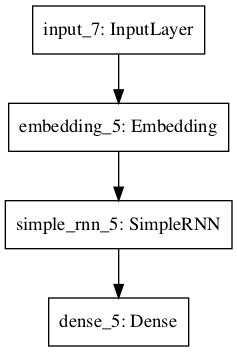

In [74]:
plot_model(model1)

In [75]:
#model1.layers[0].set_weights([embedding_matrix, np.zeros((EMBEDDING_DIM,))])

# We're freezing Embedding layer
#model1.layers[0].trainable = False

In [76]:
model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [77]:
history1 = model1.fit(X_train, y_train,
                     epochs=10,
                     batch_size=32,
                     validation_data=(X_valid, y_valid))

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 15s 836us/sample - loss: 0.7016 - accuracy: 0.5217 - val_loss: 0.7041 - val_accuracy: 0.5178
Epoch 2/10
18000/18000 [==============================] - 14s 787us/sample - loss: 0.6706 - accuracy: 0.5927 - val_loss: 0.6950 - val_accuracy: 0.5356
Epoch 3/10
18000/18000 [==============================] - 13s 736us/sample - loss: 0.6449 - accuracy: 0.6251 - val_loss: 0.6326 - val_accuracy: 0.6631
Epoch 4/10
18000/18000 [==============================] - 14s 758us/sample - loss: 0.6057 - accuracy: 0.6800 - val_loss: 0.6431 - val_accuracy: 0.6560
Epoch 5/10
18000/18000 [==============================] - 14s 775us/sample - loss: 0.5677 - accuracy: 0.7144 - val_loss: 0.7513 - val_accuracy: 0.5456
Epoch 6/10
18000/18000 [==============================] - 14s 753us/sample - loss: 0.5467 - accuracy: 0.7255 - val_loss: 0.6592 - val_accuracy: 0.6562
Epoch 7/10
18000/18000 [=====================

In [78]:
def create_accuracy_plot(acc, val_acc):
    epochs = range(1, len(acc)+1)
    plt.clf()
    plt.figure(figsize=(8,6));
    plt.plot(epochs, acc, 'bo', label='Training Acc', color='coral');
    plt.plot(epochs, val_acc, 'b', label='Val Acc', color='coral');
    plt.title('Trainig vs Validation Acc');
    plt.grid(True);
    plt.legend();
    plt.show();

In [79]:
def create_loss_plot(loss, validation_loss):
    epochs = range(1, len(loss)+1)
    plt.clf()
    plt.figure(figsize=(8,6));
    plt.plot(epochs, loss, 'bo', label='Training Loss');
    plt.plot(epochs, validation_loss, 'b', label='Val Loss');
    plt.title('Trainig vs Validation Loss');
    plt.grid(True);
    plt.legend();
    plt.show();

<Figure size 432x288 with 0 Axes>

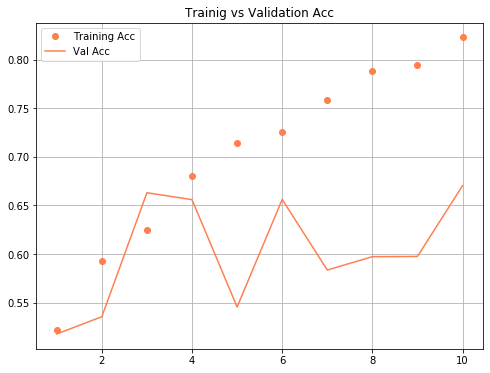

In [80]:
create_accuracy_plot(history1.history['accuracy'], history1.history['val_accuracy']);

<Figure size 432x288 with 0 Axes>

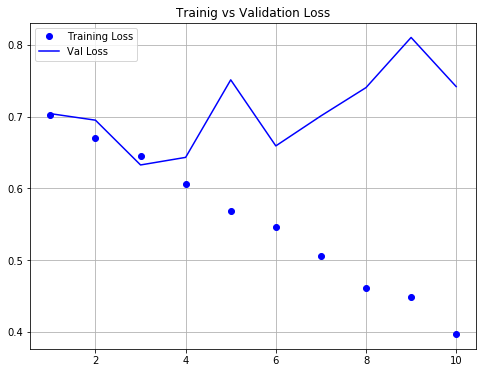

In [81]:
create_loss_plot(history1.history['loss'], history1.history['val_loss'])

In [287]:
model1.save_weights('pre_trained_glove_wiki_100D_model.h5')

#### Adding return sequences in SimpleRNN

In [90]:
def create_model_2():
    
    inputs = Input(shape=(MAX_LEN, )) #
    x = Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, \
                  weights=[embedding_matrix], input_length=MAX_LEN)(inputs)
    x = SimpleRNN(EMBEDDING_DIM, return_sequences=True)(x)
    x = SimpleRNN(EMBEDDING_DIM, return_sequences=True)(x)
    x = SimpleRNN(EMBEDDING_DIM, return_sequences=True)(x)
    x = SimpleRNN(EMBEDDING_DIM)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [91]:
model2 = create_model_2()
model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])


In [92]:
history2 = model2.fit(X_train, y_train,
                     epochs=10,
                     batch_size=32,Ω
                     validation_data=(X_valid, y_valid))

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 48s 3ms/sample - loss: 0.6999 - accuracy: 0.5003 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/10
18000/18000 [==============================] - 48s 3ms/sample - loss: 0.6957 - accuracy: 0.4991 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 3/10
18000/18000 [==============================] - 48s 3ms/sample - loss: 0.6961 - accuracy: 0.4982 - val_loss: 0.7005 - val_accuracy: 0.5020
Epoch 4/10
18000/18000 [==============================] - 47s 3ms/sample - loss: 0.6950 - accuracy: 0.5078 - val_loss: 0.7039 - val_accuracy: 0.4889
Epoch 5/10
18000/18000 [==============================] - 44s 2ms/sample - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6763 - val_accuracy: 0.5882
Epoch 6/10
18000/18000 [==============================] - 44s 2ms/sample - loss: 0.6912 - accuracy: 0.5377 - val_loss: 0.6886 - val_accuracy: 0.5424
Epoch 7/10
18000/18000 [==============================] -